In [2]:
# Imports

import pandas as pd 
import numpy as np 
from collections import Counter 
from matplotlib import pyplot as plt
%matplotlib inline
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")
import re

import nltk
from nltk.tokenize import word_tokenize 
nltk.download('punkt')
from nltk import word_tokenize
from nltk.stem import WordNetLemmatizer 
nltk.download('wordnet')
from nltk.corpus import stopwords

from wordcloud import WordCloud 

from sklearn.utils import resample
from sklearn.decomposition import TruncatedSVD 
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.kernel_approximation import RBFSampler
from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.utils import shuffle
from sklearn import preprocessing
from sklearn.cluster import KMeans
from sklearn.metrics import v_measure_score
from sklearn.metrics.cluster import adjusted_rand_score
from sklearn.cluster import AgglomerativeClustering
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer

import gensim
from gensim.utils import simple_preprocess
import gensim.corpora as corpora

import string

from textblob import TextBlob

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\cafe6\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\cafe6\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [3]:
# Dataset loading
#IF YOU WANT TO RUN THE CODE YOU MUST CHANGE THE PATH
data = pd.read_csv("C:/Users/cafe6/Documents/GitHub/Reviews.csv")

# Data cleaning & exploration 

### Dataset description

In [4]:
data.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


In [5]:
data.shape

(568454, 10)

In [6]:
print(len(data['ProductId'].unique()))
print(len(data['UserId'].unique()))

74258
256059


We have 568454 total reviews. There are 74258 unique products and 256059 unique users.

In [7]:
print(data['HelpfulnessNumerator'].describe())
print(data['HelpfulnessDenominator'].describe())

count    568454.000000
mean          1.743817
std           7.636513
min           0.000000
25%           0.000000
50%           0.000000
75%           2.000000
max         866.000000
Name: HelpfulnessNumerator, dtype: float64
count    568454.00000
mean          2.22881
std           8.28974
min           0.00000
25%           0.00000
50%           1.00000
75%           2.00000
max         923.00000
Name: HelpfulnessDenominator, dtype: float64


HelpfulnessNumerator and HelpfulnessDenominator are, respectively, the number of users who considered the review useful and the total number of users who gave an opinion on the review.
We must always have HelpfulnessNumerator <= HelpfulnessDenominator. I check this:

In [8]:
data[data['HelpfulnessNumerator'] > data['HelpfulnessDenominator']]

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
44736,44737,B001EQ55RW,A2V0I904FH7ABY,Ram,3,2,4,1212883200,Pure cocoa taste with crunchy almonds inside,It was almost a 'love at first bite' - the per...
64421,64422,B000MIDROQ,A161DK06JJMCYF,"J. E. Stephens ""Jeanne""",3,1,5,1224892800,Bought This for My Son at College,My son loves spaghetti so I didn't hesitate or...


There are two reviews that do not meet this requirement, I’m going to delete them from the dataset:

In [9]:
# Inconsistency removal

data_clean = data[data['HelpfulnessNumerator'] <= data['HelpfulnessDenominator']]
print(data_clean.shape)

(568452, 10)


In [10]:
# It might be interesting to evaluate how many people found a review helpful. I create the variable HelpfulnessRatio

data_clean['HelpfulnessRatio'] = data_clean['HelpfulnessNumerator']/data_clean['HelpfulnessDenominator']
data_clean["HelpfulnessRatio"] = pd.to_numeric(data_clean["HelpfulnessRatio"])

In [11]:
print(data['Score'].describe())

count    568454.000000
mean          4.183199
std           1.310436
min           1.000000
25%           4.000000
50%           5.000000
75%           5.000000
max           5.000000
Name: Score, dtype: float64


Score values are in the range [1,5], with an average of 4.18.

### Data cleaning

- Missing values
- Duplicates

In [12]:
# Check missing values
data_clean.isnull().sum()

Id                             0
ProductId                      0
UserId                         0
ProfileName                   16
HelpfulnessNumerator           0
HelpfulnessDenominator         0
Score                          0
Time                           0
Summary                       27
Text                           0
HelpfulnessRatio          270052
dtype: int64

In [13]:
# I extract UserId corresponding to rows with missing "ProfileName"

missing_names = list(data_clean[data_clean['ProfileName'].isnull()]['UserId'])

In [14]:
[i for i in missing_names if i in data_clean['UserId']]

[]

I checked if the UserId corresponding to the users with missing names were present in the dataset for other reviews, so as to (possibly) extract the corresponding name of the user. This does not happen.
In any case, the username is not so important, so we do not delete these records.

In [15]:
# Missing values for Summary

data_clean[data_clean['Summary'].isnull()].head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,HelpfulnessRatio
33958,33959,B00412W76S,A3TJPSWY2HE4BS,"S. Layton ""homeschool blogger""",1,24,2,1173312000,NaN,I only used two maybe three tea bags and got p...,0.041667
40548,40549,B00020HHRW,A3TJPSWY2HE4BS,"S. Layton ""homeschool blogger""",1,24,2,1173312000,NaN,I only used two maybe three tea bags and got p...,0.041667
101106,101107,B0014B0HWK,A3TJPSWY2HE4BS,"S. Layton ""homeschool blogger""",1,24,2,1173312000,NaN,I only used two maybe three tea bags and got p...,0.041667
102979,102980,B000FVDWU4,A3TJPSWY2HE4BS,"S. Layton ""homeschool blogger""",1,24,2,1173312000,NaN,I only used two maybe three tea bags and got p...,0.041667
117515,117516,B0016B7Z32,A3TJPSWY2HE4BS,"S. Layton ""homeschool blogger""",1,24,2,1173312000,NaN,I only used two maybe three tea bags and got p...,0.041667


I notice that most of these records seem to be duplicates. In general, however, a missing Summary is not particularly important, so I do not eliminate these records either.

In [16]:
# Duplicate checking


data_clean.duplicated(subset = ["UserId","ProfileName","Time","Text"]).sum()

174521

There are 174521 reviews that are duplicates of some other review (same user, same time, same comment). We delete the duplicates:

In [17]:
df = data_clean.drop_duplicates(subset = ["UserId","ProfileName","Time","Text"])

In [18]:
print(df.shape)
print(100-df.shape[0]/data.shape[0]*100)

(393931, 11)
30.701340829688945


Almost 170,000 reviews were deleted (about 30% of the initial ones).

In [19]:
# Correct format for "Time"

df["Time"] = pd.to_datetime(df.Time,  unit='s')

In [20]:
# I replace the missing values of ProfileName and Summary with empty strings. I don’t do anything for HelpfulnessRatio for now

df["ProfileName"] = df["ProfileName"].fillna('')
df["Summary"] = df["Summary"].fillna('')

### Exploration

- Score distribution
- Score vs. HelpfulnessRatio / Score vs. N° of words
- N° Reviews vs. HelpfulnessRatio / N° Reviews vs. Year
- WordCloud

In [21]:
df.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,HelpfulnessRatio
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,2011-04-27,Good Quality Dog Food,I have bought several of the Vitality canned d...,1.0
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,2012-09-07,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...,NaN
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,2008-08-18,"""Delight"" says it all",This is a confection that has been around a fe...,1.0
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,2011-06-13,Cough Medicine,If you are looking for the secret ingredient i...,1.0
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,2012-10-21,Great taffy,Great taffy at a great price. There was a wid...,NaN


Text(0, 0.5, 'Number of reviews')

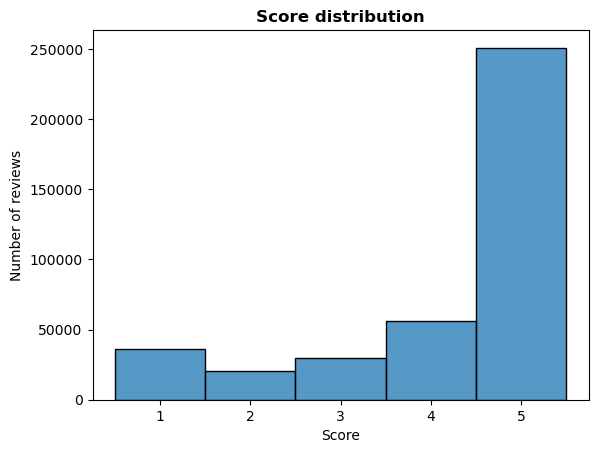

In [22]:
# Score distribution

sns.histplot(df['Score'], discrete=True)
plt.title("Score distribution", fontweight='bold')
plt.xlabel("Score")
plt.ylabel("Number of reviews")

In [23]:
print(df['Score'].value_counts());
print(df['Score'].value_counts()/len(df['Score']));

5    250961
4     56093
1     36306
3     29769
2     20802
Name: Score, dtype: int64
5    0.637068
4    0.142393
1    0.092163
3    0.075569
2    0.052806
Name: Score, dtype: float64


It might be interesting to evaluate the conditional distribution of Score against other variables. In particular, it might be interesting to evaluate the number of words per review and HelpfulnessRatio

Text(0, 0.5, 'HelpfulnessRatio')

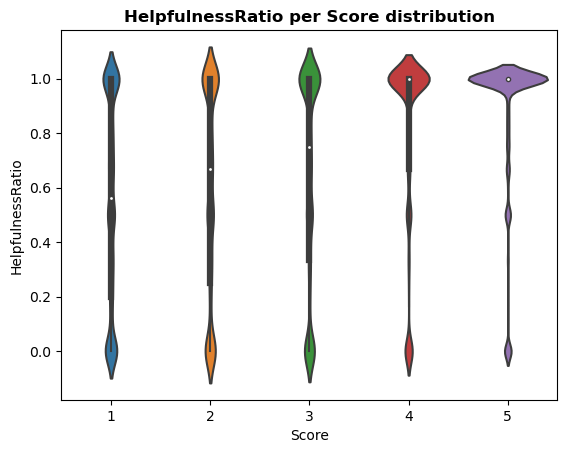

In [24]:
sns.violinplot(df, x="Score", y="HelpfulnessRatio")
plt.title("HelpfulnessRatio per Score distribution", fontweight='bold')
plt.xlabel("Score")
plt.ylabel("HelpfulnessRatio")

In [25]:
# I create the variable "WordCount" for the number of words per review

df["WordCount"] = df["Text"].apply(lambda x: len(x.split()))

Text(0, 0.5, 'WordCount')

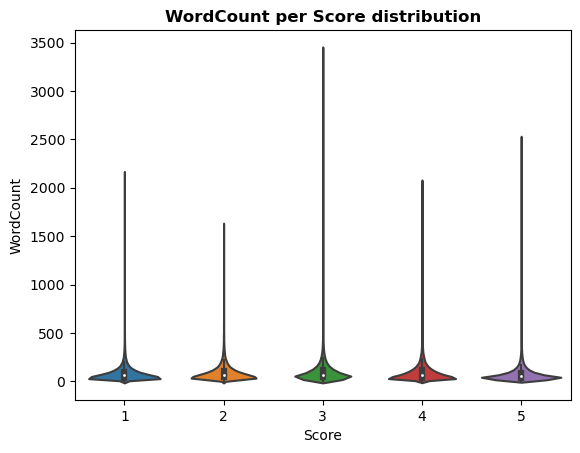

In [26]:
sns.violinplot(df, x="Score", y="WordCount")
plt.title("WordCount per Score distribution", fontweight='bold')
plt.xlabel("Score")
plt.ylabel("WordCount")

Text(0, 0.5, 'WordCount')

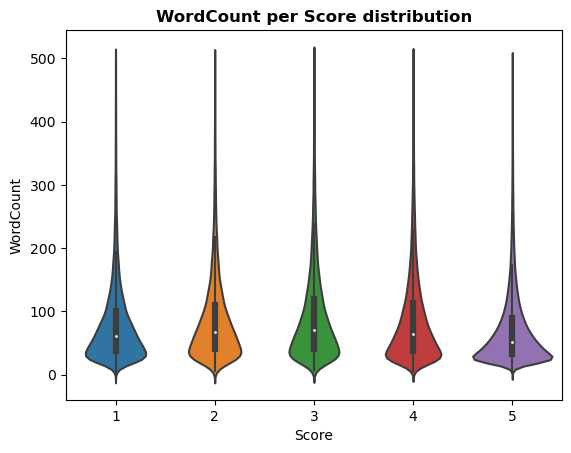

In [29]:
# I keep just the reviews with less than 500 words in order to generate a more readable graph

sns.violinplot(df[df['WordCount']<500], x="Score", y="WordCount")
plt.title("WordCount per Score distribution", fontweight='bold')
plt.xlabel("Score")
plt.ylabel("WordCount")

Text(0.5, 1.0, 'Reviews per year distribution')

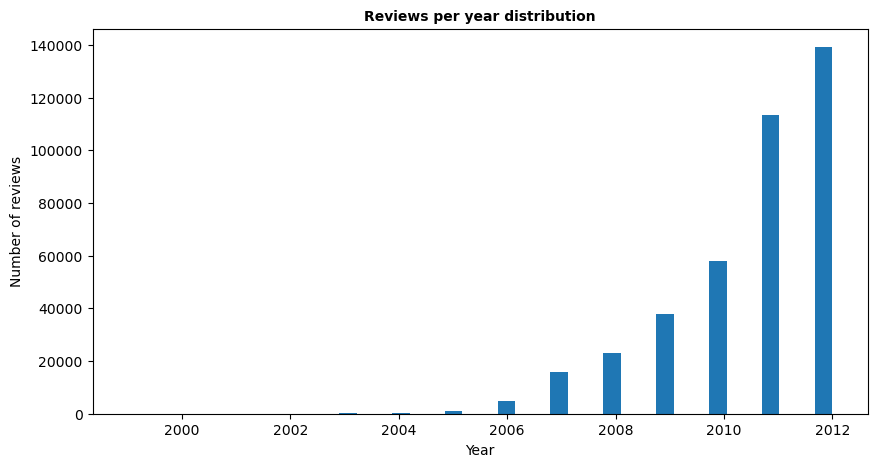

In [29]:
plt.figure(figsize=(10,5))
plt.hist(df["Time"].dt.year, bins=40)
plt.ylabel('Number of reviews')
plt.xlabel('Year')
plt.title('Reviews per year distribution', fontweight='bold', fontsize=10)

Text(0.5, 1.0, 'Reviews per Helpfulness Ratio')

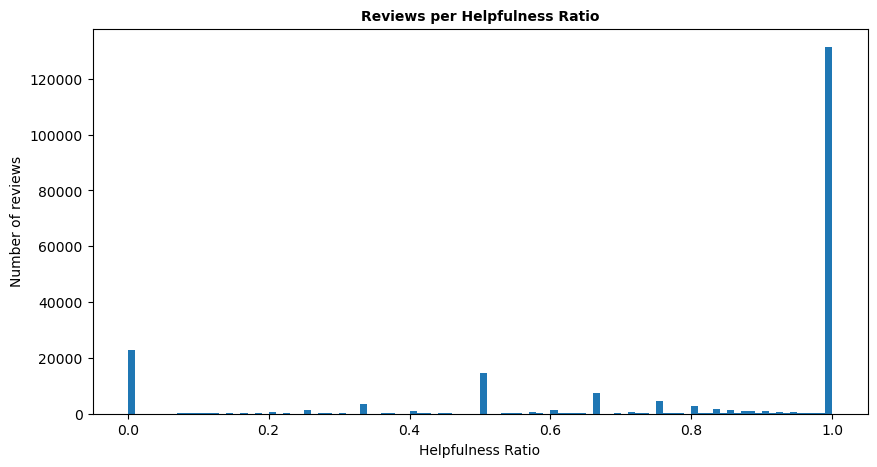

In [30]:
df_help = df[df["HelpfulnessRatio"].notnull()]

plt.figure(figsize=(10,5))
plt.hist(df_help['HelpfulnessRatio'], bins = 100)
plt.ylabel('Number of reviews')
plt.xlabel('Helpfulness Ratio')
plt.title('Reviews per Helpfulness Ratio', fontweight='bold', fontsize=10)

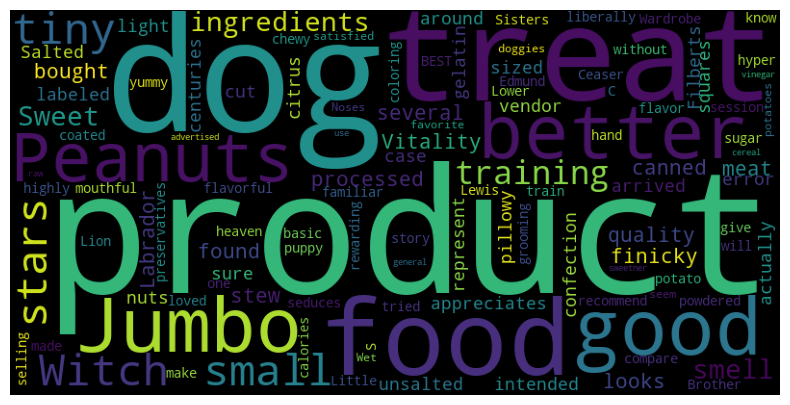

In [31]:
text_values = df['Text'].values 

wordcloud = WordCloud(width=800, height=400, collocations=False).generate(str(text_values))

plt.figure(figsize=(10,5))
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

# Preprocessing

### Normalization 

- Lower case
- Removing duplicate characters and spelling correction
- Removal of numbers
- Removal of emoji
- URL and HTML tag removal
- Removing punctuation and special characters

Normalization functions definition:

In [32]:
def text_to_lower(phrase):
    phrase = phrase.lower()
    return phrase

# Ref: "https://gist.github.com/n1n9-jp/5857d7725f3b14cbc8ec3e878e4307ce" - "http://www.unicode.org/charts/"
# If we notice other emoji just add the corresponding code

def rm_emojis(phrase):
    emoj = re.compile("["
        u"\U00002700-\U000027BF"  # Dingbats
        u"\U0001F600-\U0001F64F"  # Emoticons
        u"\U00002600-\U000026FF"  # Miscellaneous Symbols
        u"\U0001F300-\U0001F5FF"  # Miscellaneous Symbols And Pictographs
        u"\U0001F900-\U0001F9FF"  # Supplemental Symbols and Pictographs
        u"\U0001FA70-\U0001FAFF"  # Symbols and Pictographs Extended-A
        u"\U0001F680-\U0001F6FF"  # Transport and Map Symbols
        u"\U0001F1E0-\U0001F1FF"  # Flags (iOS)
                      "]+", re.UNICODE)
    return re.sub(emoj, '', phrase)

def rm_url(phrase):
    remove_https = re.sub(r'http\S+', '', phrase)
    remove_com = re.sub(r"www.[A-Za-z]*\.com", " ", remove_https)
    return remove_com

def rm_html_tags(phrase):
    clean = re.compile('<.*?>')
    return re.sub(clean, '', phrase)

def rm_repeated_char(phrase):
    pattern = re.compile(r"([A-Za-z])\1{2,}", re.DOTALL)
    clean_text = pattern.sub(r"\1\1", phrase) 
    return clean_text

def spelling_correction(phrase):
    textBlb = TextBlob(phrase)        
    textCorrected = textBlb.correct()
    textCorrected = str(textCorrected)
    return textCorrected

def rm_numbers(phrase):
    phrase_no_num = re.sub(r'\d+', '', phrase)
    return phrase_no_num

def rm_punct_symb(phrase):
    phrase_no_punct = "".join([i for i in phrase if i not in string.punctuation])
    return phrase_no_punct

In [33]:
def normalization(phrase):
    output = text_to_lower(phrase)
    output = rm_emojis(output)
    output = rm_url(output)
    output = rm_html_tags(output)
    output = rm_repeated_char(output)
    output = spelling_correction(output)
    output = rm_numbers(output)
    output = rm_punct_symb(output)
    return output

In [33]:
df.shape

(393931, 12)

In [34]:
# Dataset splitting for parallelization

df_1 = df.iloc[:39000,:]
df_2 = df.iloc[39000:78000,:]
df_3 = df.iloc[78000:117000,:]
df_4 = df.iloc[117000:156000,:]
df_5 = df.iloc[156000:195000,:]
df_6 = df.iloc[195000:234000,:]
df_7 = df.iloc[234000:273000,:]
df_8 = df.iloc[273000:312000,:]
df_9 = df.iloc[312000:351000,:]
df_10 = df.iloc[351000:,:]

In [35]:
# I apply normalization for each subset

#df1_normalized = df_1
#df1_normalized['Normalized Text'] = df_1['Text'].apply(normalization)
#df1_normalized.to_csv('C:/Users/cafe6/Documents/GitHub/Dati TextMining/df1_normalized.csv')

#print('Done')

#df2_normalized = df_2
#df2_normalized['Normalized Text'] = df_2['Text'].apply(normalization)
#df2_normalized.to_csv('C:/Users/cafe6/Documents/GitHub/Dati TextMining/df2_normalized.csv')

#print('Done')

#df3_normalized = df_3
#df3_normalized['Normalized Text'] = df_3['Text'].apply(normalization)
#df3_normalized.to_csv('C:/Users/cafe6/Documents/GitHub/Dati TextMining/df3_normalized.csv')

#print('Done')

#df4_normalized = df_4
#df4_normalized['Normalized Text'] = df_4['Text'].apply(normalization)
#df4_normalized.to_csv('C:/Users/cafe6/Documents/GitHub/Dati TextMining/df4_normalized.csv')

#print('Done')

#df5_normalized = df_5
#df5_normalized['Normalized Text'] = df_5['Text'].apply(normalization)
#df5_normalized.to_csv('C:/Users/cafe6/Documents/GitHub/Dati TextMining/df5_normalized.csv')

#print('Done')

#df6_normalized = df_6
#df6_normalized['Normalized Text'] = df_6['Text'].apply(normalization)
#df6_normalized.to_csv('C:/Users/cafe6/Documents/GitHub/Dati TextMining/df6_normalized.csv')

#print('Done')

#df7_normalized = df_7
#df7_normalized['Normalized Text'] = df_7['Text'].apply(normalization)
#df7_normalized.to_csv('C:/Users/cafe6/Documents/GitHub/Dati TextMining/df7_normalized.csv')

#print('Done')

#df8_normalized = df_8
#df8_normalized['Normalized Text'] = df_8['Text'].apply(normalization)
#df8_normalized.to_csv('C:/Users/cafe6/Documents/GitHub/Dati TextMining/df8_normalized.csv')

#print('Done')

#df9_normalized = df_9
#df9_normalized['Normalized Text'] = df_9['Text'].apply(normalization)
#df9_normalized.to_csv('C:/Users/cafe6/Documents/GitHub/Dati TextMining/df9_normalized.csv')

#print('Done')

#df10_normalized = df_10
#df10_normalized['Normalized Text'] = df_10['Text'].apply(normalization)
#df10_normalized.to_csv('C:/Users/cafe6/Documents/GitHub/Dati TextMining/df10_normalized.csv')

Done
Done
Done


In [37]:
df1_normalized = pd.read_csv('C:/Users/cafe6/Documents/GitHub/Dati TextMining/df1_normalized.csv')
df2_normalized = pd.read_csv('C:/Users/cafe6/Documents/GitHub/Dati TextMining/df2_normalized.csv')
df3_normalized = pd.read_csv('C:/Users/cafe6/Documents/GitHub/Dati TextMining/df3_normalized.csv')
df4_normalized = pd.read_csv('C:/Users/cafe6/Documents/GitHub/Dati TextMining/df4_normalized.csv')
df5_normalized = pd.read_csv('C:/Users/cafe6/Documents/GitHub/Dati TextMining/df5_normalized.csv')
df6_normalized = pd.read_csv('C:/Users/cafe6/Documents/GitHub/Dati TextMining/df6_normalized.csv')
df7_normalized = pd.read_csv('C:/Users/cafe6/Documents/GitHub/Dati TextMining/df7_normalized.csv')
df8_normalized = pd.read_csv('C:/Users/cafe6/Documents/GitHub/Dati TextMining/df8_normalized.csv')
df9_normalized = pd.read_csv('C:/Users/cafe6/Documents/GitHub/Dati TextMining/df9_normalized.csv')
df10_normalized = pd.read_csv('C:/Users/cafe6/Documents/GitHub/Dati TextMining/df10_normalized.csv')

In [45]:
# Recreate the complete dataset

df_normalized = pd.concat([df1_normalized, df2_normalized, df3_normalized, df4_normalized, df5_normalized, df6_normalized, df7_normalized, df8_normalized, df9_normalized, df10_normalized])
df_normalized.drop('Unnamed: 0', axis = 1, inplace=True)
df_normalized.to_csv('C:/Users/cafe6/Documents/GitHub/Dati TextMining/df_normalized_complete.csv')

### Tokenization

In [62]:
df_normalized = pd.read_csv('C:/Users/cafe6/Documents/GitHub/Dati TextMining/df_normalized_complete.csv')

In [50]:
df_normalized[df_normalized['Normalized Text'].isna()]

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,HelpfulnessRatio,WordCount,Normalized Text
5575,93596,B004IJMVQK,A1FJTIEV5LJYJE,David Crenshaw,3,4,5,2008-03-08,Great Buy!!! By buying in bulk and auto-ship ...,"<a href=""http://www.amazon.com/gp/product/B000...",0.750000,15,NaN
11760,101733,B002WD93EW,AR1AKOSLSZ3K9,"Kindredspirit0806 ""DEB""",1,3,5,2010-09-10,Starbucks T-discs,"<a href=""http://www.amazon.com/gp/product/B002...",0.333333,17,NaN
26835,346480,B001CHH3QY,A3QZZ2NRCC41D6,D. Sandvick,0,1,5,2009-06-14,producte review,"<a href=""http://www.amazon.com/gp/product/B001...",0.000000,17,NaN
7548,446364,B000LKZTR8,A1ZPHPEOCVIRCH,"LEE A. ""lmcc@charter.net""",1,7,4,2007-11-24,WORKS AS PROMISED,"<a href=""http://www.amazon.com/gp/product/B000...",0.142857,15,NaN


There are problems during normalization with HTML tags removal. I do not understand where the problem lies, since applying functions one at a time within normalization there are no problems. In any case, the review text in those cases is given exclusively by the product name (manually checked). I’ll remove those lines and proceed to tokenization.

In [64]:
df_normalized = df_normalized[df_normalized['Normalized Text'].notna()]

In [66]:
df_tokenized = df_normalized
df_tokenized['Tokenized Text'] = df_normalized['Normalized Text'].apply(word_tokenize)

In [79]:
df_tokenized.to_csv('C:/Users/cafe6/Documents/GitHub/Dati TextMining/df_tokenized_complete.csv')

### Stop-words removal

I also remove any words of a single letter not present in the stop words list

In [99]:
df_tokenized = pd.read_csv('C:/Users/cafe6/Documents/GitHub/Dati TextMining/df_tokenized_complete.csv')

In [107]:
# When loading the .csv, the column 'Tokenized Text' reads it as strings and no longer as word lists. Since the function for
# the removal of stop-words wants to input a list, if you load from the outside the dataframe you must return the column in the format required
# I do this by taking advantage of the function previously used to remove excess quotes and commas, while then use split to make the string a list

df_tokenized['Tokenized Text'] = df_tokenized['Tokenized Text'].apply(rm_punct_symb)
df_tokenized['Tokenized Text'] = df_tokenized['Tokenized Text'].str.split(' ')

In [112]:
stop_words = nltk.corpus.stopwords.words('english')

def stopwords_removal(text, stopwords_list):
    return ([word for word in text if ((word not in stopwords_list) and (len(word) > 1))])

In [113]:
df_no_stop_words = df_tokenized
df_no_stop_words['Text_No_Stop_Words'] = df_tokenized['Tokenized Text'].apply(lambda x: stopwords_removal(x, stop_words))

In [115]:
df_no_stop_words.to_csv('C:/Users/cafe6/Documents/GitHub/Dati TextMining/df_without_stopwords.csv')

### Lemmatization

In [120]:
nltk.download('wordnet')
nltk.download('omw-1.4')
wordnet_lemmatizer = WordNetLemmatizer()

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\cafe6\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\cafe6\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [121]:
def lemmatizer(tokens):
    lemmas = []
    for word in tokens:
        lemmas.append(wordnet_lemmatizer.lemmatize(word))
    return lemmas

In [131]:
df_lemmatized = df_no_stop_words
df_lemmatized['Lemmatized Text'] = df_no_stop_words['Text_No_Stop_Words'].apply(lemmatizer)

In [ ]:
df_lemmatized.to_csv('C:/Users/cafe6/Documents/GitHub/Dati TextMining/df_lemmatized.csv')